# Installation

In [2]:
!pip -q install monai pytorch-lightning git+https://github.com/NVIDIA/dllogger git+https://github.com/NVIDIA/mlperf-common.git -U rich
!pip -q install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

In [5]:
!pip -q install nibabel

# Data pre-processing
Create 2 folders 1 file:<br>
Folder1 = images: stack 4 input MRIs into one (240, 240, 155, 4) for each case <br>
Fodler2 = labels: split the seg mask into this folder for each case<br>
file = dataset.jason: mapped each image and corresponding label, mapped label names

In [6]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "-" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["t2f", "t1n", "t1c", "t2w"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "-seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "-seg.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "-" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "t2f" in f or "t1n" in f or "t1c" in f or "t2w" in f:
                    continue
                if "-seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train=True):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "t2f", "1": "t1n", "2": "t1c", "3": "t2w"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS23 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

prepare_dataset("/raid/compass/mobarak/datasets/brats2023/train/train_valid", train=True)
prepare_dataset("/raid/compass/mobarak/datasets/brats2023/valid/official_valid", train=False)
print("Finished!")

Preparing BraTS23 dataset from: /raid/compass/mobarak/datasets/brats2023/train/train_valid
Preparing time: 192.16
Finished!


Checking stacked images and labels:

In [7]:
import nibabel as nib
import numpy as np
img = nib.load('/raid/compass/mobarak/datasets/brats2023/train/train_valid/images/BraTS-GLI-00000-000.nii.gz')
lab = nib.load('/raid/compass/mobarak/datasets/brats2023/train/train_valid/labels/BraTS-GLI-00000-000-seg.nii.gz')
print('Stacked Images:', img.get_fdata().shape, 'Label:', lab.get_fdata().shape)

Stacked Images: (240, 240, 155, 4) Label: (240, 240, 155)


Cropping and Normalizing:
1. Transpose stacked volume in to pytorch format [B x C x D x H x W] <br>
1. Creating a folder with name 11_3d and store 4 normalized files for each case:<br>
(i) _x.npy (): To distinguish between background voxels and normalized voxels which have values close to zero, we add an input channel with one-hot encoding for foreground voxels and stacked with the input data. As a result, each example has 5 channels.<br>
(ii) _y.npy(): Cropped label which is same as _orig_lbl.npy()<br>
(iii) _orig_lbl.npy(): cropped original label<br>
(iv) _meta.npy(): cropping information with 4 coordinates:[[zmin, xmin, ymin], [zmax, xmax, ymax],[z, x, y],[zcrop, xcrop, ycrop]<br>
2. config.pkl: a dictionary with the information of patch size, channel and classes like<br>
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4 'in_channels': 5}

In [1]:
!python3 preprocess.py --task 11 --ohe --exec_mode training --data /raid/compass/mobarak/datasets/brats2023/train --results /raid/compass/mobarak/datasets/brats2023/train/train_valid
!python3 preprocess.py --task 12 --ohe --exec_mode test --data /raid/compass/mobarak/datasets/brats2023/valid --results /raid/compass/mobarak/datasets/brats2023/valid/official_valid

Preprocessing /raid/compass/mobarak/datasets/brats2023/train/train_valid
Pre-processing time: 678.75


visualization after normalised and cropped

_x: (5, 146, 171, 136) _y: (1, 146, 171, 136) _orig_lbl: (1, 146, 171, 136) _meta: (4, 3)
_meta: [[  4  40  52]
 [150 211 188]
 [155 240 240]
 [146 171 136]]
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4, 'in_channels': 5}


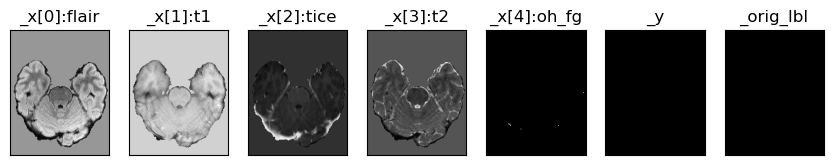

In [3]:
import matplotlib.pyplot as plt
import numpy as np
root = '/raid/compass/mobarak/datasets/brats2023/train/train_valid/'
_x = np.load(root+'11_3d/BraTS-GLI-00000-000_x.npy')
_y = np.load(root+'11_3d/BraTS-GLI-00000-000_y.npy')
_orig_lbl = np.load(root+'11_3d/BraTS-GLI-00000-000_orig_lbl.npy')
_meta = np.load(root+'11_3d/BraTS-GLI-00000-000_meta.npy')
print('_x:',_x.shape,'_y:', _y.shape,'_orig_lbl:', _orig_lbl.shape,'_meta:', _meta.shape)
print('_meta:',_meta)

import pickle
with open(root+'11_3d/config.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

num_img = 7
slice_n = 40
fig, ax = plt.subplots(1, num_img, figsize=(1.5*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(_x[0,slice_n,], cmap='gray')
ax[0].set_title('_x[0]:flair')
ax[1].imshow(_x[1,slice_n,], cmap='gray')
ax[1].set_title('_x[1]:t1')
ax[2].imshow(_x[2,slice_n,], cmap='gray')
ax[2].set_title('_x[2]:tice')
ax[3].imshow(_x[3,slice_n,], cmap='gray')
ax[3].set_title('_x[3]:t2')
ax[4].imshow(_x[4,slice_n,], cmap='gray')
ax[4].set_title('_x[4]:oh_fg')
ax[5].imshow(_y[0,slice_n,], cmap='gray')
ax[5].set_title('_y', );
ax[6].imshow(_orig_lbl[0,slice_n,], cmap='gray')
ax[6].set_title('_orig_lbl');